In [1]:
from utils import *
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
from sklearn.neural_network import MLPRegressor as MLPR
from scipy import optimize
from scipy.stats import pearsonr, spearmanr

In [2]:
def runner(
    fried_num, noise = 0.0, norm = False, 
    ntk_depth = (3, 100),
    nn_width = 500,
    figs = False,
    diagnostic=False
    ):

    if type(ntk_depth) == int:
        ntk_depth = (ntk_depth,)

    return_vals = {
        'info' : f"Friedman {fried_num} Noise = {noise} Norm = {norm}",
        'Dataset' : f'Friedman {fried_num}',
        'Noise': False if noise == 0.0 else True,
        'Norm' : norm
        }
    print(
        return_vals['info']
    )   
    
    X_init, y_init = [None, None]
    if fried_num==1:
        X_init, y_init = make_friedman1(noise=noise, random_state=18397425)
    elif fried_num==2:
        X_init, y_init = make_friedman2(noise=noise, random_state=18397425)
    elif fried_num==3:
        X_init, y_init = make_friedman3(noise=noise, random_state=18397425)
    else:
        return Exception("fried_num must be either 1, 2, or 3")
    
    datasets = processing(X_init, y_init)
    X, y, X_train, y_train = [None, datasets['orig'][1], None, datasets['orig train'][1]]

    if norm:
        X = datasets['norm'][0]
        X_train = datasets['norm train'][0]
    else:
        X = datasets['orig'][0]
        X_train = datasets['orig train'][0]

    outputs = {}
    for kernel_depth in ntk_depth:
        # GAUSSIAN PROCESS
        print('NTK : ', end='')
        ntk = (
            ConstantKernel(
                constant_value=1, 
                constant_value_bounds=(1e-9, 1e2)
            ) * 
            NTK(depth=kernel_depth, c=2, 
                bias=1e-1, 
                bias_bounds=(1e-9, 1e0)
            ) 
        )

        if noise != 0.0:
            ntk = (
                ConstantKernel(
                    constant_value=1, 
                    constant_value_bounds=(1e-9, 1e2)
                ) * 
                NTK(depth=kernel_depth, c=2, 
                    bias=1e-1, 
                    bias_bounds=(1e-9, 1e0)
                ) + WhiteKernel()
            )

        gp_ntk = GPR(kernel=ntk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
        gp_ntk.fit(X_train, y_train)
        print(gp_ntk.kernel_, gp_ntk.get_params())
        mean_ntk = gp_ntk.predict(X)



        # NEURAL NETS
        print('NN  : ', end='')
        nn = MLPR(
            hidden_layer_sizes=[nn_width for i in range(0, kernel_depth)],
            activation='relu',
            solver='sgd',
            alpha=0.0,
            learning_rate_init=0.000001,
            verbose=diagnostic,
            max_fun=15000,
            max_iter=1000000,
            tol=1e-8
        )

        nn.partial_fit(X_train, y_train.ravel())
        nn.intercepts_.shape

    #     # Random normal initialization
    #     nn.loss_ = None
    #     for i in range(0, len(nn.coefs_)):
    #         nn.coefs_[i] = np.random.randn(*nn.coefs_[i].shape)
    #     for i in range(0, len(nn.intercepts_)):
    #         nn.intercepts_[i] = np.ones_like(nn.intercepts_[i])*gp_ntk.get_params()['kernel__k2__bias'] #np.random.randn(*nn.intercepts_[i].shape)
            
    #     nn.fit(X_train, y_train.ravel())
    #     mean_nn = np.expand_dims(nn.predict(X), axis=1)

    #     corr = np.corrcoef((y - mean_ntk)[:,0], (y - mean_nn)[:,0])[0,1]

    #     if figs:
    #         fig, ax = plt.subplots(1,1, figsize=(5,5))
    #         ax.scatter(y - mean_ntk, y - mean_nn)
    #         ax.set_title(f"Depth={kernel_depth}, NN Width={nn_width}\n" + 
    #         f"Nois{'eless' if noise==0.0 else 'y'} {'Normalized' if norm else 'Non-normalized'} Friedman {fried_num}")
    #         ax.set_xlabel('NTK Residuals')
    #         ax.set_ylabel('NN Residuals')
    #         fig.tight_layout()

    #     outputs['figs'] = (fig, ax)
    #     outputs['corr'] = corr

    # return outputs

Friedman 1 Noise = 0.0 Norm = True
NTK : 1.55**2 * NTK(depth=3, c=2.000, bias=0.028) {'alpha': 1e-09, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': NTK(depth=3, c=2.000, bias=0.100), 'kernel__k1__constant_value': 1, 'kernel__k1__constant_value_bounds': (1e-09, 100.0), 'kernel__k2__depth': 3, 'kernel__k2__c': 2, 'kernel__k2__bias': 0.1, 'kernel__k2__bias_bounds': (1e-09, 1.0), 'kernel': 1**2 * NTK(depth=3, c=2.000, bias=0.100), 'n_restarts_optimizer': 9, 'normalize_y': True, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 3480795}
NN  : 

/anaconda/envs/thesis/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


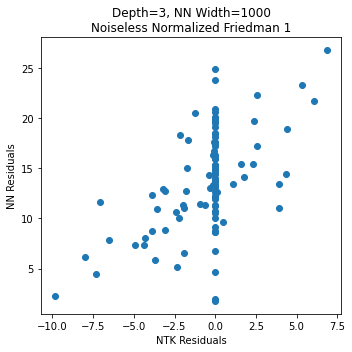

In [3]:
# fried_num, noise = 0.0, norm = False, 
#     ntk_depth = (3, 100),
#     nn_width = 500,
#     figs = False,
test_experiment = [1, 0.0, True, 3, 1000]
test = runner(*test_experiment, figs=True, diagnostic=True)

In [ ]:
X_init, y_init = make_friedman3(noise=noise, random_state=18397425)
datasets = processing(X_init, y_init)

X, y, X_train, y_train = [None, datasets['orig'][1], None, datasets['orig train'][1]]

if norm:
    X = datasets['norm'][0]
    X_train = datasets['norm train'][0]
else:
    X = datasets['orig'][0]
    X_train = datasets['orig train'][0]

n = X.shape[1]